In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import datetime
import warnings
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
warnings.filterwarnings('ignore')

# 1) Sarima Model Optimization

## 1.1) Cleaning the Data

### Saving clean DF

In [2]:
#model_df.to_csv('../data/prices_scores_clean.csv')

In [3]:
#prices_greed_df = pd.merge(prices_df,greed_df,on='date')
#prices_greed_df = prices_greed_df.set_index('date')
#prices_greed_df.to_csv('../data/prices_greed_score_clean.csv')

### Retrieving DF from folder

In [4]:
augmento_df = pd.read_csv('../data/prices_scores_clean.csv')
augmento_df.columns = ['date', 'price', 'BTC_score','twitter_score','reddit_score']
augmento_df['date'] = pd.to_datetime(augmento_df['date'])
augmento_df.columns = ['ds','y','BTC_score', 'twitter_score','reddit_score']
#model_df = model_df.set_index('date')

In [5]:
prices_greed_df = pd.read_csv('../data/prices_greed_score_clean.csv')
#prices_greed_df = prices_greed_df.set_index('date')
prices_greed_df.columns=['date','price','score']
prices_greed_df['date'] = pd.to_datetime(prices_greed_df['date'])
prices_greed_df.columns = ['ds','y','score']

In [6]:
full_df = pd.merge(prices_greed_df, augmento_df, on='ds')

In [7]:
full_df = full_df.drop_duplicates()
full_df = full_df.reset_index()
full_df = full_df[['ds','y_x','score','BTC_score', 'twitter_score','reddit_score']]
full_df.columns = ['ds','y','score','BTC_score', 'twitter_score','reddit_score']

### Train Test Split

In [8]:
train_df = prices_greed_df.loc[:1062]
test_df = prices_greed_df.loc[1062:1092]

In [9]:
train_full_df = full_df.loc[:1062]
test__full_df = full_df.loc[1062:]

# 2) Facebook Profit (Final Model to deploy)

In [ ]:
model = Prophet()
model.fit(train_df)

In [ ]:
horizon = 30
future = model.make_future_dataframe(horizon)
forecast = model.predict(future)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(prices_greed_df["y"], label="actual")
plt.plot(forecast["yhat"], label="pred")
plt.legend()

In [ ]:
fg_model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
fg_model.add_regressor("score")
fg_model.fit(train_df)

In [ ]:
horizon = 30
fg_model_future = fg_model.make_future_dataframe(horizon)
fg_model_future["score"] = prices_greed_df["score"] 
fg_forecast = fg_model.predict(fg_model_future)

In [ ]:
fg_forecast

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(prices_greed_df["y"], label="actual")
plt.plot(fg_forecast["yhat"], label="pred")
plt.legend()

## Model Iteration

In [12]:
model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
model.add_regressor("score")
model.fit(prices_greed_df[:1093])
horizon = 1
model_future = model.make_future_dataframe(horizon)
model_future["score"] = prices_greed_df["score"] 
forecast = model.predict(model_future)
forecast['yhat'][1093]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


35568.04978205923

In [17]:
forecast['ds'][1093]

Timestamp('2021-02-01 00:00:00')

In [146]:
full_df[:1093]

,ds,y,score,BTC_score,twitter_score,reddit_score
0,2018-02-01,9052.5763,30,0.496911,0.569701,0.429601
1,2018-02-02,8827.6300,15,0.479340,0.552322,0.430662
2,2018-02-03,9224.3913,40,0.495011,0.585380,0.453424
3,2018-02-04,8186.6488,24,0.499830,0.554089,0.444839
4,2018-02-05,6914.2600,11,0.469328,0.529476,0.438090
...,...,...,...,...,...,...
1088,2021-01-27,30425.3933,78,0.451524,0.568092,0.512576
1089,2021-01-28,33420.0450,55,0.461012,0.588805,0.541803
1090,2021-01-29,34264.0100,77,0.497264,0.614617,0.575444
1091,2021-01-30,34324.2717,76,0.490272,0.562461,0.525758


## Evaluation Predictions (Only Fear and Greed)

In [145]:
predictions = {}
for index in range(1093, 1122):
    model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
    model.add_regressor("score")
    model.add_regressor("reddit_score")
    model.fit(full_df[:index])
    horizon = 1
    model_future = model.make_future_dataframe(horizon)
    model_future["score"] = full_df["score"] 
    forecast = model.predict(model_future)
    predictions[forecast['ds'][index]] = forecast['yhat'][index]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ValueError: Found NaN in column 'score'

In [70]:
real_preds = {}
for key, value in predictions.items():
    real_preds[key.strftime('%Y-%m-%d')] = [value]

In [71]:
real_preds = pd.DataFrame(real_preds)
real_preds = real_preds.T
real_preds = real_preds.reset_index()
real_preds.columns = ['ds','pred']
real_preds.ds = pd.to_datetime(real_preds.ds)

In [72]:
actuals = prices_greed_df[1092:1122][['ds','y']]
actuals
comparision = pd.merge(actuals,real_preds, on='ds', how='left')
#comparision.columns = ['ds','actual','pred']
#comparision['mae'] = abs(comparision['actual'] - comparision['pred'])

In [80]:
comparision['mae'] = abs(comparision['y'] - comparision['pred'])

In [94]:
comparision['mae'].mean()

4054.472291875098

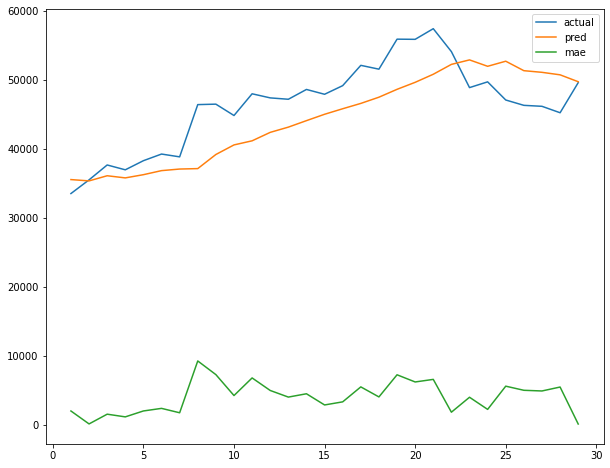

In [81]:
plt.figure(figsize=(10,8))
plt.plot(comparision[1:]['y'], label='actual')
plt.plot(comparision[1:]['pred'], label='pred')
plt.plot(comparision[1:]['mae'], label='mae')
plt.legend()
plt.show()

In [192]:
prices_greed_df[:800]

,ds,y,score
0,2018-02-01,9052.5763,30
1,2018-02-02,8827.6300,15
2,2018-02-03,9224.3913,40
3,2018-02-04,8186.6488,24
4,2018-02-05,6914.2600,11
...,...,...,...
795,2020-04-09,7314.9500,22
796,2020-04-10,6909.9500,15
797,2020-04-11,6814.0500,15
798,2020-04-12,7143.4500,10


## Evaluation Predictions 2 (Only Fear and Greed) 1 year period

In [193]:
start_index = 800

In [194]:
predictions_2 = {}
for index in range(start_index, 1122):
    model = Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=0.5)
    model.add_regressor("score")
    model.fit(prices_greed_df[:index])
    horizon = 1
    model_future = model.make_future_dataframe(horizon)
    model_future["score"] = prices_greed_df["score"] 
    forecast = model.predict(model_future)
    predictions_2[forecast['ds'][index]] = forecast['yhat'][index]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [292]:
real_preds_2 = {}
for key, value in predictions_2.items():
    real_preds_2[key.strftime('%Y-%m-%d')] = [value]

In [293]:
actuals_2 = prices_greed_df[start_index:][['ds','y']]

In [294]:
real_preds_2 = pd.DataFrame(real_preds_2)
real_preds_2 = real_preds_2.T
real_preds_2 = real_preds_2.reset_index()
real_preds_2.columns = ['ds','pred']
real_preds_2.ds = pd.to_datetime(real_preds_2.ds)

In [295]:
comparision_2 = pd.merge(actuals_2,real_preds_2, on='ds', how='left')

In [296]:
comparision_2['mae'] = abs(comparision_2['y'] - comparision_2['pred'])

In [297]:
comparision_2['actual_change'] = comparision_2['y']-comparision_2.shift(1)['y']
comparision_2['pred_change'] = comparision_2['pred']-comparision_2.shift(1)['pred']

In [298]:
comparision_2['actual_change'] = np.where(comparision_2['actual_change']>0,1,0)
comparision_2['pred_change'] = np.where(comparision_2['pred_change']>0,1,0)

In [299]:
comparision_2['correct_pred'] = np.where(comparision_2['pred_change']==comparision_2['actual_change'], 1, 0)

In [300]:
comparision_2['correct_pred'].sum()/len(comparision_2['correct_pred'])

0.5186335403726708

In [301]:
comparision_2['mae'].mean()

1084.0513863149606

In [302]:
comparision_2

,ds,y,pred,mae,actual_change,pred_change,correct_pred
0,2020-04-14,6885.1000,7114.833504,229.733504,0,0,1
1,2020-04-15,6727.1500,7238.348367,511.198367,0,1,0
2,2020-04-16,7055.8225,6969.645973,86.176527,1,0,0
3,2020-04-17,7086.8500,7130.782098,43.932098,1,1,1
4,2020-04-18,7226.6100,7177.789150,48.820850,1,1,1
...,...,...,...,...,...,...,...
317,2021-02-25,47104.7833,51967.817249,4863.033949,0,1,0
318,2021-02-26,46329.7400,50791.268343,4461.528343,0,0,1
319,2021-02-27,46189.3783,50481.113727,4291.735427,0,0,1
320,2021-02-28,45256.4133,50428.286922,5171.873622,0,0,1


In [303]:
comparision_2['previous_price'] = comparision_2.shift(1)['y']

In [304]:
comparision_2['previous_pred_change'] = comparision_2.shift(1)['pred_change']

In [308]:
comparision_2

,ds,y,pred,mae,actual_change,pred_change,correct_pred,previous_price,previous_pred_change
0,2020-04-14,6885.1000,7114.833504,229.733504,0,0,1,NaN,NaN
1,2020-04-15,6727.1500,7238.348367,511.198367,0,1,0,6885.1000,0.0
2,2020-04-16,7055.8225,6969.645973,86.176527,1,0,0,6727.1500,1.0
3,2020-04-17,7086.8500,7130.782098,43.932098,1,1,1,7055.8225,0.0
4,2020-04-18,7226.6100,7177.789150,48.820850,1,1,1,7086.8500,1.0
...,...,...,...,...,...,...,...,...,...
317,2021-02-25,47104.7833,51967.817249,4863.033949,0,1,0,49734.5200,0.0
318,2021-02-26,46329.7400,50791.268343,4461.528343,0,0,1,47104.7833,1.0
319,2021-02-27,46189.3783,50481.113727,4291.735427,0,0,1,46329.7400,0.0
320,2021-02-28,45256.4133,50428.286922,5171.873622,0,0,1,46189.3783,0.0


In [306]:
def wallet(budget):
    portfolio = budget
    btc_value = 0
    for index, row in comparision_2.iterrows():
        
        if row['pred_change']==1:
            if row['previous_pred_change']==1:
                pass
                
            if row['previous_price']==0:
                pass
            
            else:
                btc_value = (portfolio/row['previous_price'])
                print('up')
                print(portfolio)
                print(btc_value)
        else:
            if btc_value>0:
                portfolio = btc_value*row['y']
                btc_value = 0
                print('down')
                print(portfolio)
            else:
                pass
            
    return (portfolio,btc_value)

In [307]:
wallet(100)

up
100
0.014524117296771288
down
102.47959361519803
up
102.47959361519803
0.014524117296771288
up
102.47959361519803
0.014460528107014826
down
103.69138587056585
up
103.69138587056585
0.014460528107014826
up
103.69138587056585
0.01503577795524938
up
103.69138587056585
0.015122416560285535
down
114.27934582524976
up
114.27934582524976
0.015122416560285535
up
114.27934582524976
0.015231356652127813
down
115.798521337733
up
115.798521337733
0.015231356652127813
down
117.64928348453304
up
117.64928348453304
0.015231356652127813
up
117.64928348453304
0.014220099654259473
up
117.64928348453304
0.013459861394563745
down
119.67761729738683
up
119.67761729738683
0.013459861394563745
up
119.67761729738683
0.013570414059785263
down
120.78075625630676
up
120.78075625630676
0.013570414059785263
up
120.78075625630676
0.013058864941800865
up
120.78075625630676
0.012881975293842943
up
120.78075625630676
0.01209420021807142
down
102.3828472360727
up
102.3828472360727
0.011727770174637048
down
112.38232

(83.48833358311326, 0)

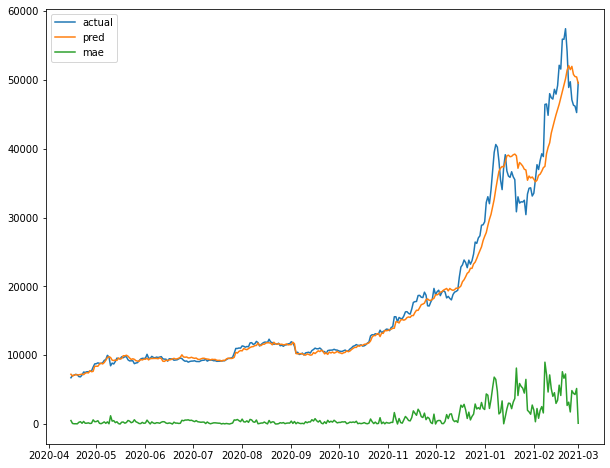

In [205]:
plt.figure(figsize=(10,8))
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['y'], label='actual')
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['pred'], label='pred')
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['mae'], label='mae')
plt.legend()
plt.show()